## Problem Statement 

Taxi companies face the problem of distributing orders among taxi drivers. How to choose the driver who will receive the next order? When and in which area should drivers wait for new customers? In particular, predicting the duration of the trip helps to answer these questions.

The aim of our work is to predict the duration of the trip, based on factors such as the place and date of pick-up and drop-off of passengers and the number of passengers.

## Dataset summary and basic statistics

#### Data summary:

**id** - a unique identifier for each trip

**vendor_id** - a code indicating the provider associated with the trip record

**pickup_datetime** - date and time when the meter was engaged

**dropoff_datetime** - date and time when the meter was disengaged, target value

**passenger_count** - the number of passengers in the vehicle (driver entered value)

**pickup_longitude** - the longitude where the meter was engaged

**pickup_latitude** - the latitude where the meter was engaged

**dropoff_longitude** - the longitude where the meter was disengaged

**dropoff_latitude** - the latitude where the meter was disengaged

**store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory 
before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

**trip_duration** - duration of the trip in seconds, target value


For the evaluation and model comparison we use RMSLE:
 $$L(a, y) = \sqrt{\frac{1}{n} \sum_{i = 1}^n (\log(a_i + 1) - \log(y_i + 1))^2} $$

In [1]:
import datetime
import numpy as np 
import pandas as pd
import os
import zipfile
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [2]:
archive = zipfile.ZipFile('/kaggle/input/nyc-taxi-trip-duration/train.zip')
data = pd.read_csv(archive.open('train.csv'))
data.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


Let us check that there are no missing values in our dataset:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Next step let us look at basic statistics summary:

In [4]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Note that min of passenger_count can not reach 0 value and because of that we will drop this values as errors.

Another statistics with supposed to be an error is max of trip_duration - 3526282 sec (~ 980 hours).

These observations prove that there are outliers in our dataset. Therefore, before proceeding to the feature generation stage, we will delete obviously erroneous data from the dataset.

In [5]:
data=data[data['passenger_count'] > 0]

In [6]:
target = data['trip_duration']
del data['trip_duration']
del data['id']
del data['dropoff_datetime']
del data['store_and_fwd_flag']

In [7]:
#splitting on train and test and removing outliers
X_train, X_test, y_train, y_test =  train_test_split(data, target, test_size = 0.2, random_state = 10)

#### Trip duration analysis 
We examine the distribution of *log* of the duration of trips.

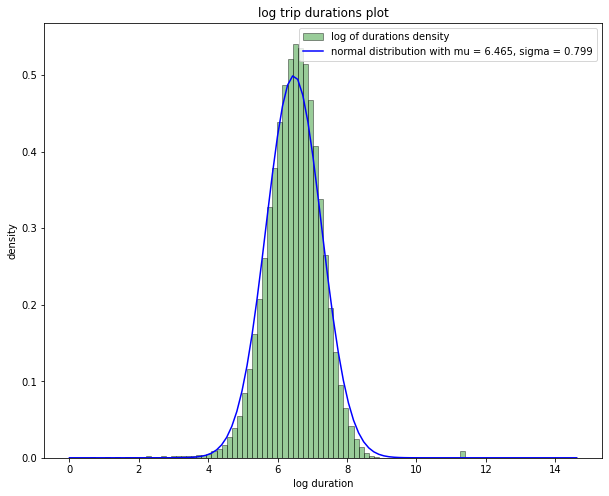

In [8]:
fig = plt.figure(figsize=(10, 8))
_, bins, _ = plt.hist(np.log(y_train), bins = 100,  density=True, edgecolor = 'black',color = 'green', alpha=0.4, label = 'log of durations density')

mu = np.log(y_train).mean()
sigma = np.log(y_train).std()
plt.plot(bins, norm.pdf(bins, mu, sigma), color = 'blue', label = 'normal distribution with mu = {:.3f}, sigma = {:.3f}'.format(mu, sigma))

plt.legend()
plt.xlabel('log duration')
plt.ylabel('density')
plt.title("log trip durations plot")
plt.show()

Note that the logarithm of the duration of trips does have almost a normal distribution. There is an unexpected increase in density of about 11.5 (which corresponds to ~ 27 hours). Let us look at these points by another way:

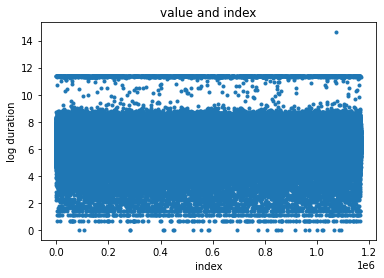

In [9]:
plt.plot(np.arange(y_train.shape[0]), np.log(y_train), '.')
plt.ylabel('log duration')
plt.xlabel('index')
plt.title('value and index')
plt.show()

It is clear to see that there are only 1 value greater than 12.However, it is likely that these values are not errors in the data, but really are long trips.

#### Time feature analysis and data-preprocessing

We are examining the dependence of the duration of trips on different time indicators: the month, the day of the week and the time of day of the trip.

In [10]:
import warnings
warnings.filterwarnings("ignore")

#first of all, switch it to datetime type
X_train['pickup_datetime'] = pd.to_datetime(X_train['pickup_datetime'])
X_test['pickup_datetime'] = pd.to_datetime(X_test['pickup_datetime'])

In [11]:
#get some time features from pickup time:
X_train['pickup_month'] = X_train['pickup_datetime'].dt.month
X_test['pickup_month'] = X_test['pickup_datetime'].dt.month
# 0 - monday, 6 - sunday
X_train['pickup_day'] = X_train['pickup_datetime'].dt.day_of_week
X_test['pickup_day'] = X_test['pickup_datetime'].dt.day_of_week
#1 if weekend 0 else
X_train['weekend_flag'] = X_train['pickup_day'] > 5
X_test['weekend_flag'] = X_test['pickup_day'] > 5 
#hour of pickup:
X_train['pickup_hour'] = X_train['pickup_datetime'].dt.hour
X_test['pickup_hour'] = X_test['pickup_datetime'].dt.hour

#### hour and log trip duration:

In [12]:
train = X_train.copy()
train['log_trip_duration'] = np.log(y_train)

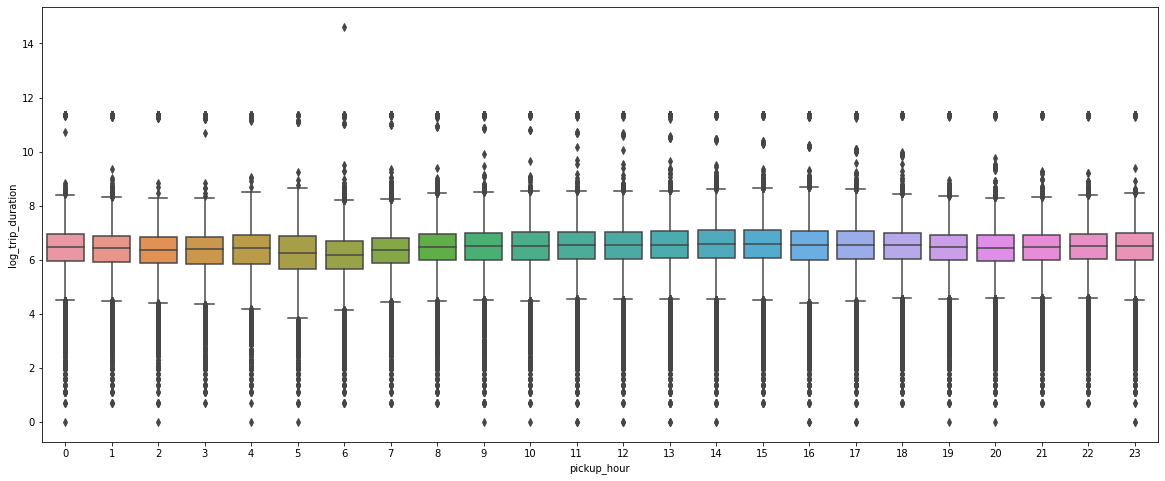

In [13]:
fig=plt.figure(figsize=(20, 8))
sns.boxplot(x="pickup_hour", y="log_trip_duration", data=train)
plt.show()

According to the schedule, it is noticeable that at lunchtime trips have a long duration.  At 6 o'clock in the morning, the trips are the shortest.

#### Month and log trip duration:

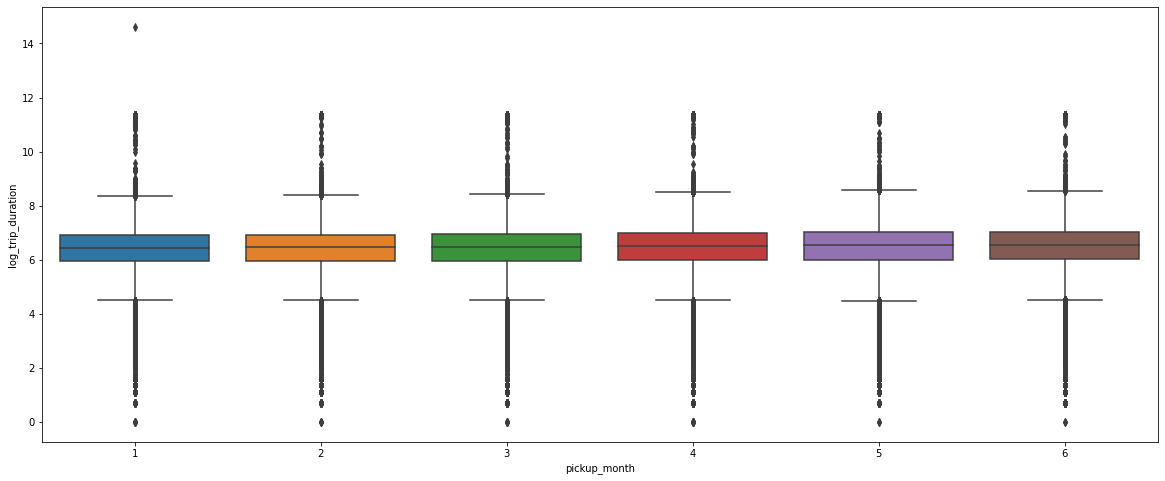

In [14]:
fig=plt.figure(figsize=(20, 8))
sns.boxplot(x="pickup_month", y="log_trip_duration", data=train)
plt.show()

The graphs look very similar.

#### weekeend and log trip duration

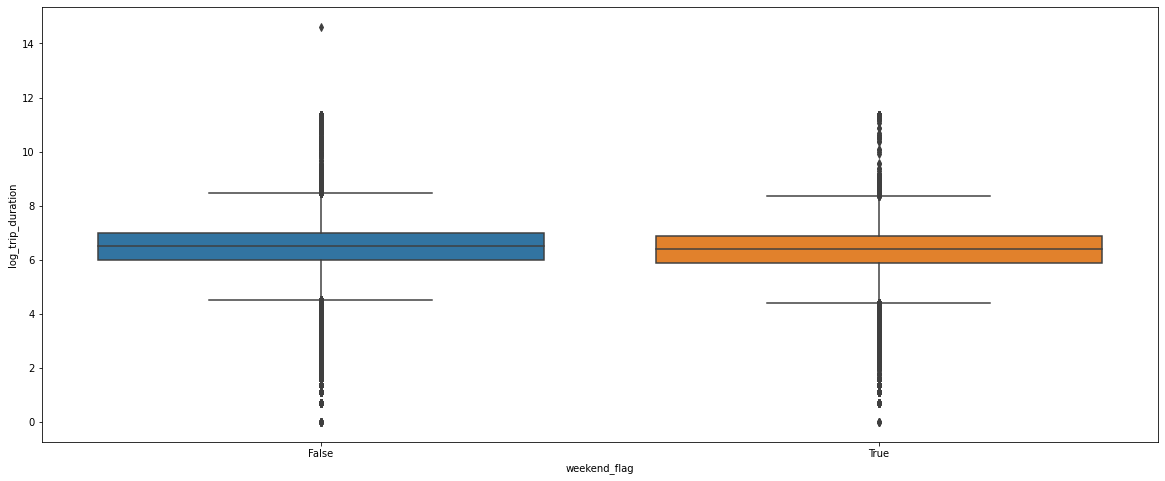

In [15]:
fig=plt.figure(figsize=(20, 8))
sns.boxplot(x="weekend_flag", y="log_trip_duration", data=train)
plt.show()

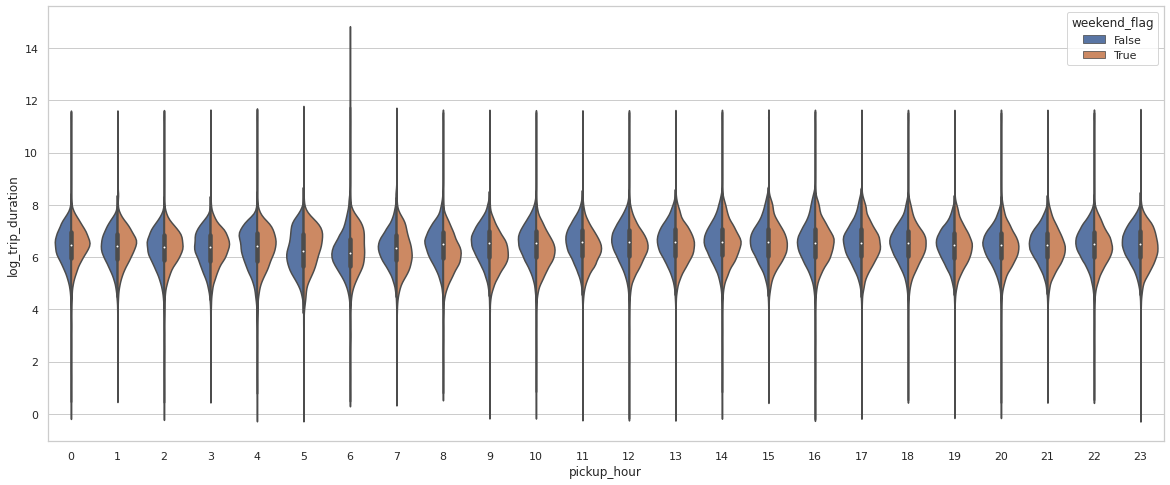

In [16]:
fig=plt.figure(figsize=(20, 8))
sns.set_theme(style="whitegrid")
sns.violinplot(x = 'pickup_hour', y="log_trip_duration", hue="weekend_flag", data=train,split=True)
plt.show()

Note that the weekend trips are a little shorter. This is quite understandable, because there are fewer traffic jams on weekends.

#### day of week and log trip duration

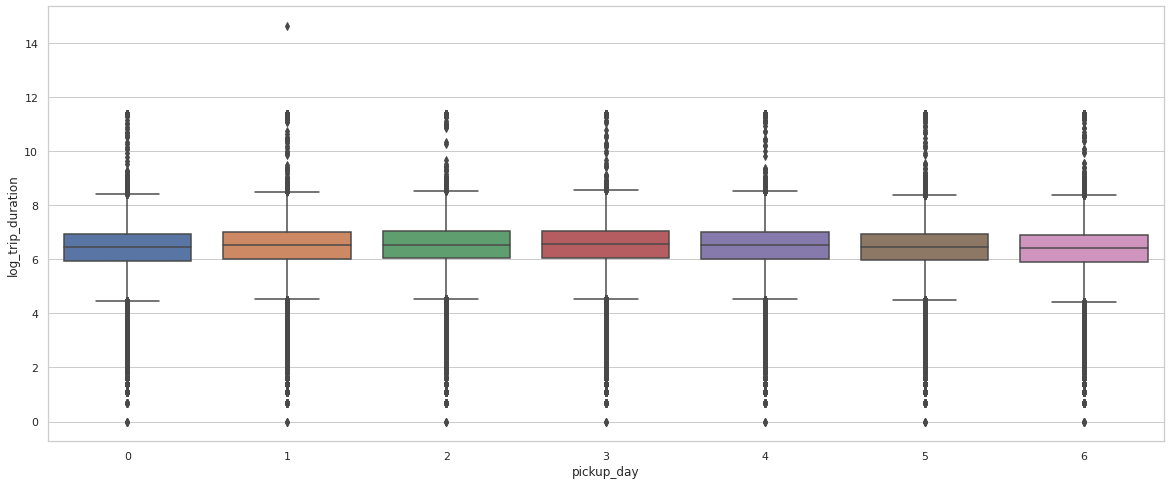

In [17]:
fig=plt.figure(figsize=(20, 8))
sns.boxplot(x="pickup_day", y="log_trip_duration", data=train)
plt.show()

Note that on Mondays and weekends, the duration of the trip is slightly less than on other days.

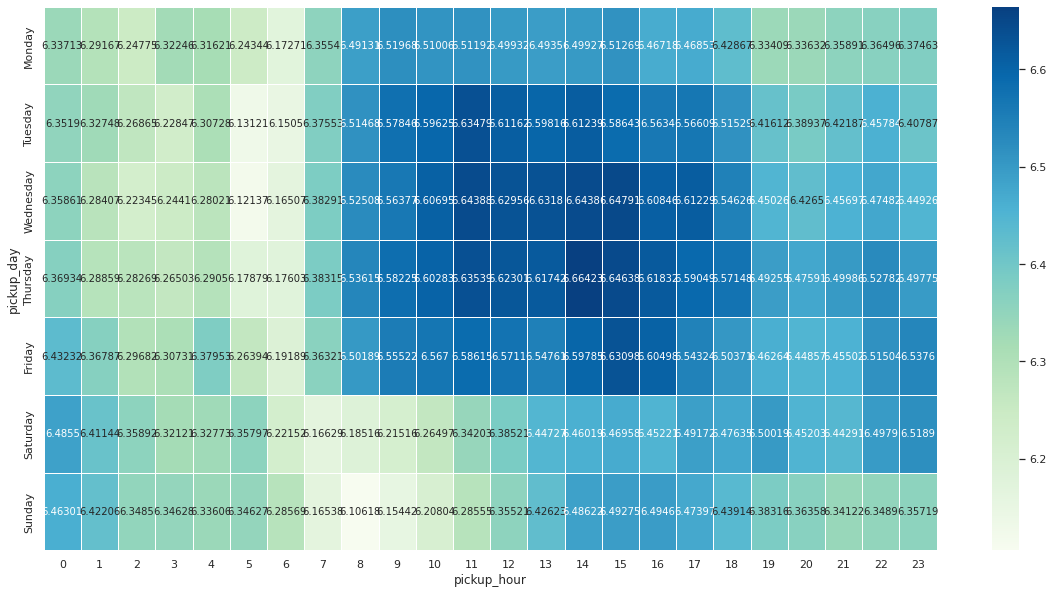

In [18]:
plt.figure(figsize=(20,10))
mean_data = train.groupby(['pickup_day', 'pickup_hour'])['log_trip_duration'].mean().unstack()
plot = sns.heatmap(mean_data, lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10})

plot.set_yticklabels(labels = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.show()

The graph above shows the average trip lengths at the corresponding hour and day of the week. Once again, we were convinced that the longest trips take place on weekdays during working hours: from 8 to 18.

Let's see what the distribution of the number of trips by day looks like in winter.

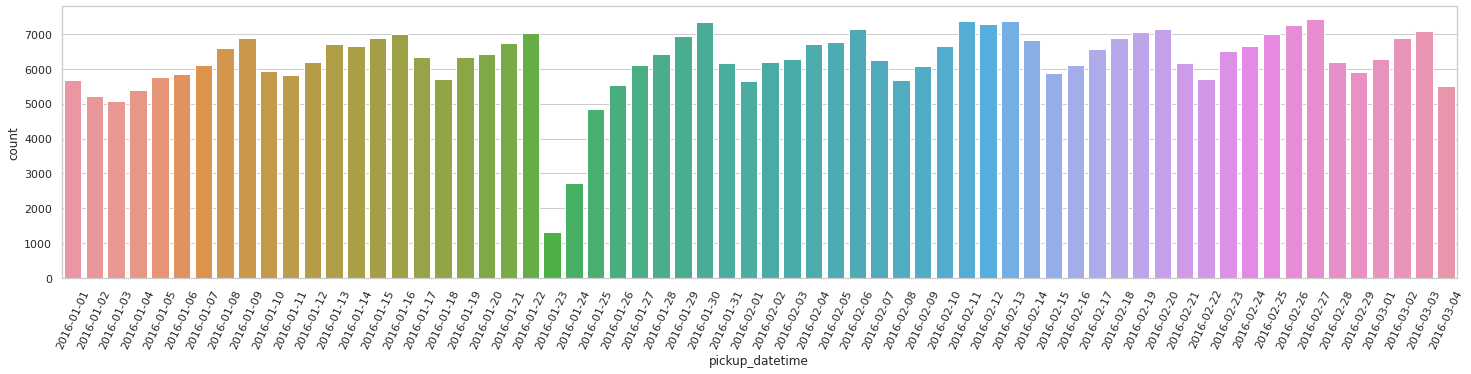

In [19]:
date_sorted = X_train.pickup_datetime.dt.date.sort_values()[:400000]
plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=65);

We can observe several abnormal values in the number of trips, specifically on 2016-01-23 and 2016-01-24.

In [20]:
X_train['anomaly'] = X_train.pickup_datetime.apply(lambda x: x.date() in [datetime.date(2016, 1, 23), datetime.date(2016, 1, 24)])
X_test['anomaly'] = X_test.pickup_datetime.apply(lambda x: x.date() in [datetime.date(2016, 1, 23), datetime.date(2016, 1, 24)])

Getting day of year for a given pickup date

In [21]:
X_train['pickup_datetime'] = X_train.pickup_datetime.apply(lambda x: x.timetuple().tm_yday)
X_test['pickup_datetime'] = X_test.pickup_datetime.apply(lambda x: x.timetuple().tm_yday)

Create a calculated field `distance_haversine`. The Haversine (or great circle) distance is the angular distance between two points on the surface of a sphere. 

In [22]:
def haversine_distance(lat1, long1, lat2, long2):
    # the unit is in km
    #r = Average of earth radius
    lat1, long1, lat2, long2 = map(np.radians, (lat1, long1, lat2, long2))
    r = 6371 
    lat = lat2 - lat1
    long = long2 - long1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(long * 0.5) ** 2
    h = 2 * r * np.arcsin(np.sqrt(d))
    return h

In [23]:
def get_distance(df):
    df.loc[:, 'distance_haversine'] = haversine_distance(df['pickup_latitude'].values, \
                                                      df['pickup_longitude'].values, \
                                                      df['dropoff_latitude'].values, \
                                                      df['dropoff_longitude'].values)
    
    return df

In [24]:
X_train = get_distance(X_train)
X_test = get_distance(X_test)

In [25]:
numeric_features = ['pickup_datetime', 'passenger_count',  'pickup_month', 'pickup_day', 'pickup_hour', 'distance_haversine', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
categorical_features = ['vendor_id', 'weekend_flag', 'anomaly']
features = numeric_features + categorical_features

## Methodology (justify the selected ML/DM approach)

First, we will try Linear Regression as it is the most widely-known regression learner.

Then we will implement a Decision Tree Regressor, which doesn't require feature scaling, computationally less expensive and easy to interpret.

The third choice will be Random Forest Regressor. The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees.

At the end, the XGBoost Regressor will be our final method. XGBoost is an efficient open-source implementation of the gradient boosting algorithm. The main reasons to use XGBoost are execution speed and model performance.

## Experiment setup and results; error analysis

In [26]:
def rmsle(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

### Apply Linear Regression

In [27]:
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Linear Regression Performance Metric')
print('RMSLE = ', rmsle(y_test, y_pred))

Linear Regression Performance Metric
RMSLE =  0.6878769376878907


RMSLE is high. This clearly indicates that the relationship between the features and the target variable is non-linear.

### Decision Tree Regressor

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': np.arange(7, 10)}
]
tree = GridSearchCV(DecisionTreeRegressor(), param_grid)
tree.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': array([7, 8, 9])}])

In [29]:
tree.best_params_

{'max_depth': 7}

In [30]:
y_pred = tree.predict(X_test)

print('Decision Tree Regression Performance Metric')
print('RMSLE = ', rmsle(y_test, y_pred))

Decision Tree Regression Performance Metric
RMSLE =  0.5915473443268164


Decision Tree Regression performs much better than Linear.

### Random Forest Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor 

rforest = RandomForestRegressor(n_estimators = 20, n_jobs = -1)

rforest = rforest.fit(X_train,y_train)

y_pred = rforest.predict(X_test)

print('Random Forest Regression Performance Metric')
print('RMSLE = ', rmsle(y_test, y_pred))

Random Forest Regression Performance Metric
RMSLE =  0.574042552383974


The best result so far.

### XGB Regressor

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

model = XGBRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('XGBRegressor Performance Metric')
print('RMSLE = ', rmsle(y_test, y_pred))

XGBRegressor Performance Metric
RMSLE =  0.5531398763433502


<!-- ###  -->

## Discussion (comparison, interpretations, etc.)

Since the relation is nonlinear linear regressions performance is the lowest.

Decision Tree Regressor performs significantly better, Random Forest Regression is even better than decision tree as expected.

XGBRegressor with default parameters performs a little bit better than Random forest regressor.

## Conclusion

- XGBRegressor demonstrates the best quality on our test dataset.

- the logarithm of the duration of trips does have almost a normal distribution

- on Mondays and weekends, the duration of the trip is slightly less than on other days

- The longest trips take place on weekdays during working hours: from 8 to 18

- We have two anomaly dates (23-24 January, 2016). The January 2016 United States blizzard was a crippling and historic blizzard that produced up to 3 ft (91 cm) of snow in parts of the Mid-Atlantic and Northeastern United States from January 22–24, 2016

- lunchtime trips have a long duration

- At 6 o'clock in the morning, the trips are the shortest

- Trip Duration varies a lot ranging from few seconds to more than 20 hours